Import relevant packages

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

Import cleaned datasets

In [11]:
housing = pd.read_csv('../datasets/housing_cleaned.csv')
prediction_data = pd.read_csv('../datasets/test_cleaned.csv')

prediction_id = prediction_data['id']

In [12]:
# drop some unhelpful columns:
housing = housing.drop(columns = ['pid', 'id', 'Unnamed: 0'])
prediction_data = prediction_data.drop(columns = [
    'saleprice','pid', 'id', 'Unnamed: 0'])

# Model Iteration 1 (Basic Linear Regression)

### Unscaled Linear Regression Model

In [13]:
#create our X and y

X = housing.drop(columns = ['saleprice'], axis = 1)
y = housing['saleprice']

In [14]:
#instantiate our lr model

house_lr = LinearRegression()

In [15]:
house_lr.fit(X, y)

LinearRegression()

In [16]:
cross_val_score(house_lr, X, y)

array([0.88173682, 0.90569568, 0.90198469, 0.89498138, 0.88319144])

In [17]:
#confidence interval for r2
#I have commented these cells out because they run VERY slowly

# mean = cross_val_score(house_lr, X, y).mean()
# std = np.std(cross_val_score(house_lr, X, y))
# mean - 2*std, mean + 2* std

We likely have some outliers in our data since we see a large range of r2 values

In [18]:
#check MSE
mean_squared_error(y, house_lr.predict(X))

604244196.3832476

In [19]:
#check the RMSE
np.sqrt(mean_squared_error(y, house_lr.predict(X)))

24581.379057799983

In [20]:
#plot the residuals
lr_error = house_lr.predict(X) - y

Text(0.5, 0, 'Actual Sale Price ($)')

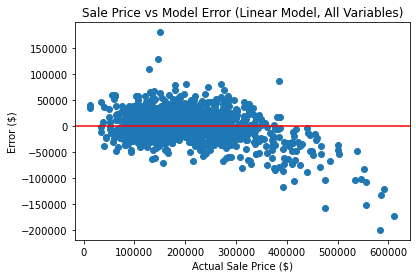

In [21]:
plt.scatter(y, lr_error)
plt.axhline(0, color = 'red')
plt.title('Sale Price vs Model Error (Linear Model, All Variables)')
plt.ylabel('Error ($)')
plt.xlabel('Actual Sale Price ($)')


<ipython-input-22-69273a9dde35>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


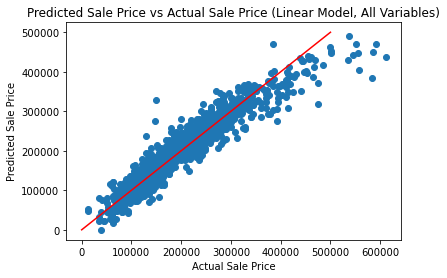

In [22]:
#check the predictions against actual values
plt.scatter(y, house_lr.predict(X))
plt.title(
    'Predicted Sale Price vs Actual Sale Price (Linear Model, All Variables)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

ax = plt.axes()
ax.plot([0,500000], [0,500000], color = 'red')

### Using Lasso to Correct Overfitting

In [23]:
#Scale the data

ss = StandardScaler()
Z_train = ss.fit_transform(X)

In [24]:
#Create a list of possible alphas
lasso_alphas = np.logspace(-5, 100, 1000)

#Instantiate our Lasso Model
lasso_cv = LassoCV(alphas = lasso_alphas, cv = 5, max_iter = 100000)

#train our model
lasso_cv.fit(Z_train, y)

LassoCV(alphas=array([1.00000000e-005, 1.27381132e-005, 1.62259529e-005, 2.06688025e-005,
       2.63281547e-005, 3.35371015e-005, 4.27199397e-005, 5.44171429e-005,
       6.93171728e-005, 8.82969996e-005, 1.12473718e-004, 1.43270295e-004,
       1.82499324e-004, 2.32469706e-004, 2.96122544e-004, 3.77204249e-004,
       4.80487044e-004, 6.12049837e-004, 7.79636013e-004, 9.93109181e-004,
       1.265033...
       3.82456972e+097, 4.87178022e+097, 6.20572881e+097, 7.90492762e+097,
       1.00693863e+098, 1.28264983e+098, 1.63385388e+098, 2.08122157e+098,
       2.65108360e+098, 3.37698031e+098, 4.30163576e+098, 5.47947234e+098,
       6.97981391e+098, 8.89096599e+098, 1.13254132e+099, 1.44264395e+099,
       1.83765620e+099, 2.34082728e+099, 2.98177229e+099, 3.79821531e+099,
       4.83820966e+099, 6.16296626e+099, 7.85045620e+099, 1.00000000e+100]),
        cv=5, max_iter=100000)

In [25]:
lasso_cv.alpha_

178.75255259042353

In [26]:
cross_val_score(lasso_cv, X, y)

array([0.88045703, 0.9027916 , 0.89934699, 0.89577136, 0.88466186])

In [27]:
#confidence interval for r2
#I have commented these cells out because they run VERY slowly

# mean = cross_val_score(lasso_cv, X, y).mean()
# std = np.std(cross_val_score(lasso_cv, X, y))
# mean - 2*std, mean + 2* std

In [28]:
#RMSE

np.sqrt(mean_squared_error(y, lasso_cv.predict(Z_train)))

24680.891530678262

In [29]:
#Create a list displaying all the coefficients of our new model

terms_zero = list(zip(X.columns, lasso_cv.coef_))

In [30]:
#create a list of terms that we can drop from our DF

terms_to_zero = []
for item_pair in terms_zero:
    if item_pair[1] == 0:
        terms_to_zero.append(item_pair[0])

In [31]:
terms_to_zero

['street',
 'exterior_2nd',
 'paved_drive',
 'misc_val',
 'mo_sold',
 'has_pool',
 'neighborhood_Edwards',
 'neighborhood_Greens',
 'neighborhood_Sawyer']

In [32]:
#Drop the terms that got zeroed out by our Lasso

In [33]:
lasso_reduced_df = housing.drop(columns = terms_to_zero)

### doing a basic linear regression with our newly reduced DF

In [34]:
#create our X and y

X = lasso_reduced_df.drop(columns = ['saleprice'], axis = 1)
y = lasso_reduced_df['saleprice']

In [35]:
#Scale the data

ss = StandardScaler()
Z_train = ss.fit_transform(X)

In [36]:
#instantiate our lr model

house_lr2 = LinearRegression()

In [37]:
#fit the model

house_lr2.fit(Z_train, y)

LinearRegression()

In [38]:
#cross val score

cross_val_score(house_lr2, Z_train, y)

array([0.88200979, 0.90627387, 0.90221059, 0.89609873, 0.88542794])

In [39]:
#MSE
np.sqrt(mean_squared_error(y, house_lr2.predict(Z_train)))

24617.51828110314

### making predictions for submission

In [40]:
testcols = list(prediction_data.columns)
traincols = list(X.columns)
no_overlap = []

for col in testcols:
    if col not in traincols:
        no_overlap.append(col)
        
prediction_data1 = prediction_data.drop(columns = no_overlap)

In [41]:
predictions = house_lr2.predict(ss.fit_transform(prediction_data1))

submission_2 = pd.DataFrame(zip(prediction_id, predictions))

submission_2.rename(columns = {0:'Id', 1:'SalePrice'}, inplace = True)

submission_2.to_csv(
    '../submission predictions/Prediction2.csv', index = False)

Doing a regression with 63 columns on so few observations feels like a case of overfitting. I do not feel that lasso has removed enough variables and so I will examine the results of a ridge regression to see if that changes anything. 

# Ridge Regression

In [42]:
#create and transform our X and y

X = housing.drop(columns = ['saleprice'])
y = housing['saleprice']

ss = StandardScaler()
Z_train = ss.fit_transform(X)



In [43]:
#create list of possible alphas
ridge_alphas = np.logspace(0, 20, 200)

#instantiate model
ridge_cv = RidgeCV(alphas = ridge_alphas, scoring = 'r2', cv = 5)

In [44]:
#fit our model

ridge_cv.fit(Z_train, y)

RidgeCV(alphas=array([1.00000000e+00, 1.26038293e+00, 1.58856513e+00, 2.00220037e+00,
       2.52353917e+00, 3.18062569e+00, 4.00880633e+00, 5.05263107e+00,
       6.36824994e+00, 8.02643352e+00, 1.01163798e+01, 1.27505124e+01,
       1.60705282e+01, 2.02550194e+01, 2.55290807e+01, 3.21764175e+01,
       4.05546074e+01, 5.11143348e+01, 6.44236351e+01, 8.11984499e+01,
       1.02341140e+02, 1.28989026e+0...
       4.88025158e+17, 6.15098579e+17, 7.75259749e+17, 9.77124154e+17,
       1.23155060e+18, 1.55222536e+18, 1.95639834e+18, 2.46581108e+18,
       3.10786619e+18, 3.91710149e+18, 4.93704785e+18, 6.22257084e+18,
       7.84282206e+18, 9.88495905e+18, 1.24588336e+19, 1.57029012e+19,
       1.97916687e+19, 2.49450814e+19, 3.14403547e+19, 3.96268864e+19,
       4.99450512e+19, 6.29498899e+19, 7.93409667e+19, 1.00000000e+20]),
        cv=5, scoring='r2')

In [45]:
cross_val_score(ridge_cv, Z_train, y)

array([0.88199718, 0.90605642, 0.90126687, 0.89592075, 0.88378822])

In [46]:
#confidence interval for r2
#I have commented these cells out because they run VERY slowly

# mean = cross_val_score(ridge_cv, X, y).mean()
# std = np.std(cross_val_score(ridge_cv, X, y))
# mean - 2*std, mean + 2* std

In [47]:
#MSE
np.sqrt(mean_squared_error(y, ridge_cv.predict(Z_train)))

24609.69281140888

In [48]:
coeffs = list(zip(X.columns, ridge_cv.coef_))

In [49]:
testcols = list(prediction_data.columns)
traincols = list(X.columns)
no_overlap = []

for col in testcols:
    if col not in traincols:
        no_overlap.append(col)

prediction_data1 = prediction_data.drop(columns = no_overlap)

In [50]:
predictions = ridge_cv.predict(ss.fit_transform(prediction_data1))

submission_4 = pd.DataFrame(zip(prediction_id, predictions))

submission_4.rename(columns = {0:'Id', 1:'SalePrice'}, inplace = True)

submission_4.to_csv(
    '../submission predictions/prediction4.csv', index = False)

Ridge regression does not seem to zero out our terms aggressively enough, and I am hoping to create a model with far fewer variables for simplicity of interpretation and ease of use. I will next attempt to create a model, dropping irrelevant variables based on their correllation with the dependent variable. 

# Dropping variables manually by examining corellation

<AxesSubplot:>

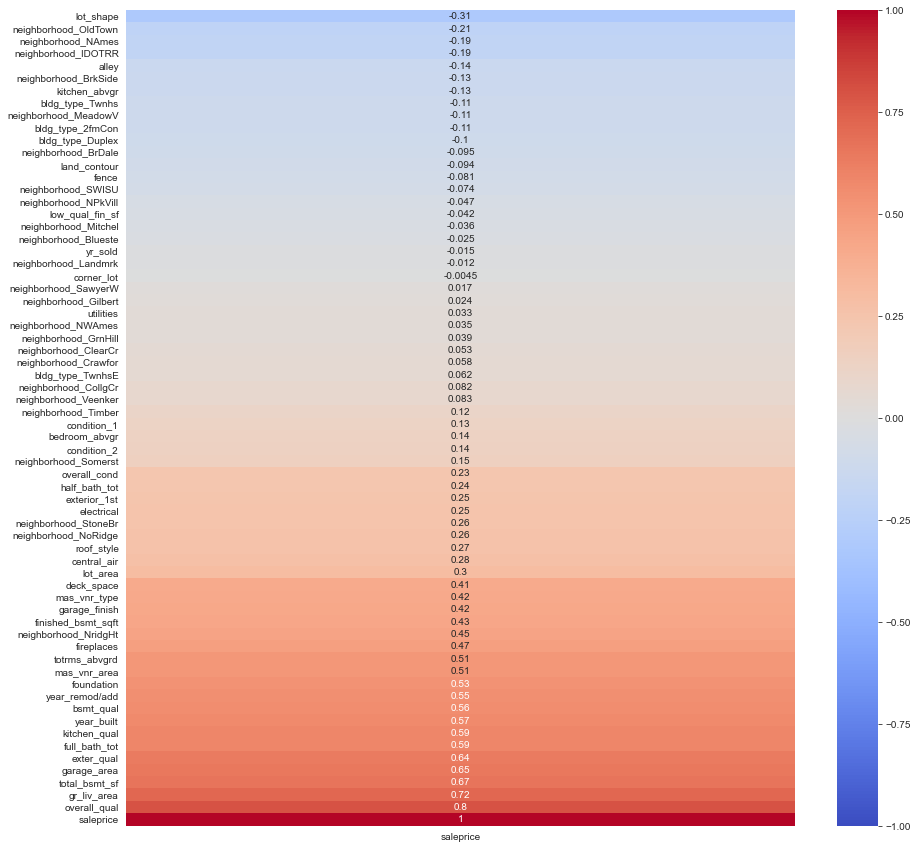

In [51]:
sns.set_style('dark')
plt.figure(figsize=(15,15))
correlation = lasso_reduced_df.corr()[['saleprice']].sort_values('saleprice')
sns.heatmap(data = correlation,
    vmin= -1,
    vmax= 1,
    cmap= 'coolwarm',
    annot=True,
)

We currently have a huge number of terms, even after dropping some using lasso. I will be selecting a semi-arbitrary cutoff of |0.2|, and dropping terms that do not meet this criteria

In [52]:
correlation = pd.DataFrame(lasso_reduced_df.corr()[['saleprice']])
correlation['variable'] = lasso_reduced_df.columns
correlation.rename(columns = {'saleprice':'corr'}, inplace = True)

In [53]:
low_corr = correlation[correlation['corr'] < 0.2]

In [54]:
low_corr_drop = list(low_corr['variable'])

In [55]:
#drop the low correlation variables
housing_high_corr = lasso_reduced_df.drop(columns = low_corr_drop, axis = 1)

# Linear Model with high corr variables only

In [56]:
#instantiate model
housing_lr3 = LinearRegression()

#create X and y
X = housing_high_corr.drop(columns = ['saleprice'])
y = housing_high_corr['saleprice']

Z = ss.fit_transform(X)
#fit model
housing_lr3.fit(Z, y)

LinearRegression()

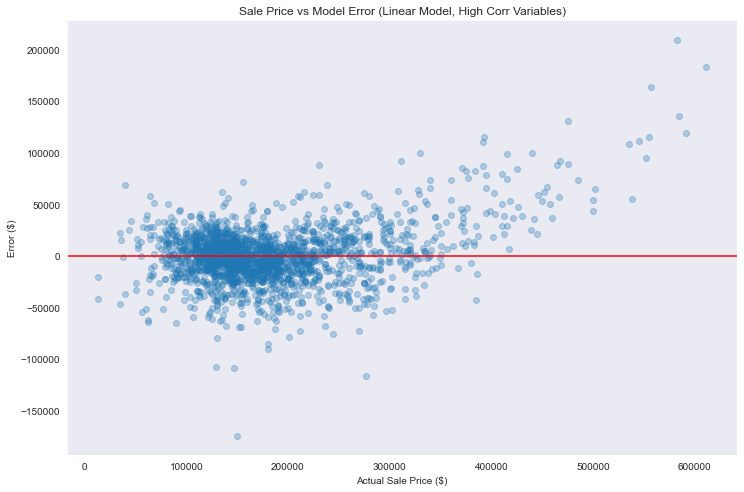

In [57]:
#examine the residuals
lr_error = y - housing_lr3.predict(Z)
plt.figure(figsize=(12,8))
plt.scatter(y, lr_error, alpha = 0.3)
plt.axhline(0, color = 'red')
plt.title('Sale Price vs Model Error (Linear Model, High Corr Variables)')
plt.ylabel('Error ($)')
plt.xlabel('Actual Sale Price ($)')
plt.savefig('../figures/saleprce_modelerror_highcorr', transparent = True)

<ipython-input-58-42e9ad1f1fe9>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


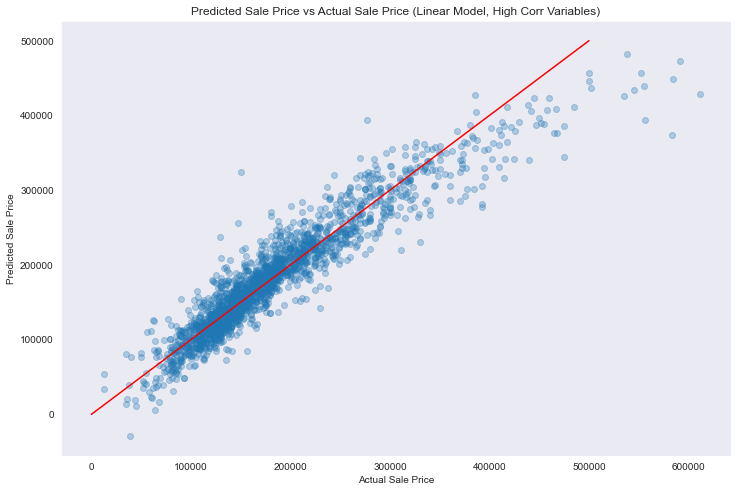

In [58]:
#check the predictions against the actual prices
plt.figure(figsize=(12,8))
plt.scatter(y, housing_lr3.predict(Z), alpha = 0.3)
plt.title(
    'Predicted Sale Price vs Actual Sale Price (Linear Model, High Corr Variables)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

ax = plt.axes()
ax.plot([0,500000], [0,500000], color = 'red')
plt.savefig('../figures/actual_predicted_highcorr', transparent = True)


We still see our model struggling to predict the Sale Price of expensive homes. Next I will try including some interaction terms to see how it impacts our models performance.

In [59]:
X.shape

(2047, 28)

In [60]:
#check the cross val scores of our new model
cross_val_score(housing_lr3, Z, y, cv = 5)

array([0.86672094, 0.87072171, 0.88759836, 0.88671126, 0.87693098])

In [61]:
#confidence interval for r2
#I have commented these cells out because they run VERY slowly

# mean = cross_val_score(housing_lr3, X, y).mean()
# std = np.std(cross_val_score(housing_lr3, X, y))
# mean - 2*std, mean + 2* std

In [62]:
#RMSE
np.sqrt(mean_squared_error(y, housing_lr3.predict(Z)))

26828.558483240544

In [63]:
#Coefficients

coefficients = pd.DataFrame(list(zip(X.columns, housing_lr3.coef_)))
coefficients.rename(
    columns = {0:'Variable Name', 1:'Coefficient'}, inplace = True)
coefficients.sort_values('Coefficient', ascending = False)

,Variable Name,Coefficient
15,gr_liv_area,21369.734838
1,overall_qual,18003.621796
24,finished_bsmt_sqft,10926.232298
26,neighborhood_NridgHt,8908.029089
12,total_bsmt_sf,8153.299691
27,neighborhood_StoneBr,6993.912477
3,year_built,6939.877823
8,mas_vnr_area,6855.485829
20,garage_area,6674.267434
0,lot_area,6300.917466


Since I have standardized the data for modeling, the above coefficients show the relative impact of each of my independent variables. The most impactful variables are gr_liv_area which represents the total above grade square footage of a home, overall_quality, finish_bsmt_sqft which represents the total finished basement square footage, and neighborhood_NridgeHt which indicates if a property is in a desireable neighborhood called Northridge Heights.

To my surprise, some of the variables that have a negative impact on sale price include full and half bath total, and having air conditioning.

### predictions

In [64]:
testcols = list(prediction_data.columns)
traincols = list(X.columns)
no_overlap = []

for col in testcols:
    if col not in traincols:
        no_overlap.append(col)

prediction_data2 = prediction_data.drop(columns = no_overlap)

In [65]:
predictions = housing_lr3.predict(prediction_data2)

submission_3 = pd.DataFrame(zip(prediction_id, predictions))

submission_3.rename(columns = {0:'Id', 1:'SalePrice'}, inplace = True)

submission_3.to_csv(
    '../submission predictions/Prediction3.csv', index = False)

In [66]:
submission_3

,Id,SalePrice
0,2658,1.362190e+08
1,2718,1.495873e+08
2,2414,1.809925e+08
3,1989,1.120853e+08
4,625,1.397081e+08
...,...,...
873,1662,1.409406e+08
874,1234,1.832715e+08
875,1373,1.221536e+08
876,1672,1.185423e+08


The linear model with only high correlation variables runs quite well for being a fairly limited model. It has a relatively high R2 value given our dataset, and the predictions perform in the kaggle submission.

# Lasso With the high corr values

In [67]:
#create our X and y

X = housing_high_corr.drop(columns = ['saleprice'])
y = housing_high_corr['saleprice']

#Scale the data

ss = StandardScaler()
Z_train = ss.fit_transform(X)

#Create a list of possible alphas
lasso_alphas = np.logspace(-10, 50, 1000)

#Instantiate our Lasso Model
lasso_cv = LassoCV(alphas = lasso_alphas, cv = 5, max_iter = 100000)

#train our model
lasso_cv.fit(Z_train, y)

LassoCV(alphas=array([1.00000000e-10, 1.14831241e-10, 1.31862140e-10, 1.51418933e-10,
       1.73876240e-10, 1.99664245e-10, 2.29276931e-10, 2.63281547e-10,
       3.02329468e-10, 3.47168682e-10, 3.98658107e-10, 4.57784054e-10,
       5.25679112e-10, 6.03643851e-10, 6.93171728e-10, 7.95977700e-10,
       9.14031075e-10, 1.04959323e-09, 1.20526094e-09, 1.38401610e-09,
       1.58928287e-09, 1.82499324e-0...
       4.15545533e+48, 4.77176095e+48, 5.47947234e+48, 6.29214611e+48,
       7.22534949e+48, 8.29695852e+48, 9.52750047e+48, 1.09405471e+49,
       1.25631660e+49, 1.44264395e+49, 1.65660596e+49, 1.90230119e+49,
       2.18443607e+49, 2.50841506e+49, 2.88044415e+49, 3.30764978e+49,
       3.79821531e+49, 4.36153779e+49, 5.00840799e+49, 5.75121707e+49,
       6.60419396e+49, 7.58367791e+49, 8.70843150e+49, 1.00000000e+50]),
        cv=5, max_iter=100000)

In [68]:
lasso_cv.alpha_

19.55650715865947

In [69]:
mean_squared_error(y, lasso_cv.predict(Z_train))

719789775.8563824

In [70]:
#RMSE

np.sqrt(mean_squared_error(y, lasso_cv.predict(Z_train)))

26828.89814838437

In [71]:
cross_val_score(lasso_cv, Z_train, y)

C:\Users\jg_ri\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32340087546.70215, tolerance: 794833728.4868665
  model = cd_fast.enet_coordinate_descent_gram(


array([0.86577004, 0.87097462, 0.88765543, 0.88690658, 0.87692266])

These R2 values are lower than I had hoped, there is some amount of variance in the data the the model is still not capturing. I will try including interaction terms next to see if that helps with the fit of the model

In [72]:
#Create a list displaying all the coefficients of our new model

terms_zero = list(zip(X.columns, lasso_cv.coef_))

#create a list of terms that we can drop from our DF

terms_to_zero = []
for item_pair in terms_zero:
    if item_pair[1] == 0:
        terms_to_zero.append(item_pair[0])

This lasso does not zero out any of our terms. next we will try interaction terms. 

# Model with Interaction terms

Look at the correlations in our manually reduced dataset, and create some interaction terms for the 

In [73]:
housing_high_corr.head()

,lot_area,overall_qual,overall_cond,year_built,year_remod/add,roof_style,exterior_1st,mas_vnr_type,mas_vnr_area,exter_qual,...,garage_finish,garage_area,saleprice,deck_space,half_bath_tot,full_bath_tot,finished_bsmt_sqft,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_StoneBr
0,13517,6,1,1976,2005,0,1,1,289.0,1,...,0,475.0,130500,44,1.0,2.0,533.0,0,0,0
1,11492,7,1,1996,1997,0,1,1,132.0,1,...,0,559.0,220000,74,1.0,3.0,637.0,0,0,0
2,7922,5,1,1953,2007,0,1,0,0.0,0,...,0,246.0,109000,52,0.0,2.0,731.0,0,0,0
3,9802,5,1,2006,2007,0,1,0,0.0,0,...,1,400.0,174000,100,1.0,2.0,0.0,0,0,0
4,14235,6,1,1900,1993,0,0,0,0.0,0,...,0,484.0,138500,59,0.0,2.0,0.0,0,0,0


In [74]:
correlation = housing_high_corr.corr()[['saleprice']].sort_values('saleprice')
correlation

#overall_qual, gr_liv_area, total_bsmt_sf, garage_area, exter_qual are the top 5 corr values

,saleprice
overall_cond,0.234623
half_bath_tot,0.236899
exterior_1st,0.246554
electrical,0.252727
neighborhood_StoneBr,0.257183
neighborhood_NoRidge,0.263605
roof_style,0.265584
central_air,0.277662
lot_area,0.302394
deck_space,0.408879


In [75]:
#create subset of just the 5 variables we want to create interaction terms for
housing_poly = housing[['overall_qual', 
                        'gr_liv_area', 
                        'total_bsmt_sf', 
                        'garage_area', 
                        'exter_qual']]

In [76]:
#create the polynomial features
from sklearn.preprocessing import PolynomialFeatures
features = [
    'overall_qual','gr_liv_area','total_bsmt_sf','garage_area','exter_qual']

poly = PolynomialFeatures(
    degree = 2, interaction_only = False, include_bias = False)

housing_poly2 = pd.DataFrame(poly.fit_transform(housing_poly), 
                             columns = poly.get_feature_names(features))

In [77]:
housing_poly2.drop(columns = ['overall_qual', 
                        'gr_liv_area', 
                        'total_bsmt_sf', 
                        'garage_area', 
                        'exter_qual'], inplace = True)

In [78]:
housing_poly2

,overall_qual^2,overall_qual gr_liv_area,overall_qual total_bsmt_sf,overall_qual garage_area,overall_qual exter_qual,gr_liv_area^2,gr_liv_area total_bsmt_sf,gr_liv_area garage_area,gr_liv_area exter_qual,total_bsmt_sf^2,total_bsmt_sf garage_area,total_bsmt_sf exter_qual,garage_area^2,garage_area exter_qual,exter_qual^2
0,36.0,8874.0,4350.0,2850.0,6.0,2187441.0,1072275.0,702525.0,1479.0,525625.0,344375.0,725.0,225625.0,475.0,1.0
1,49.0,14854.0,6391.0,3913.0,7.0,4502884.0,1937386.0,1186198.0,2122.0,833569.0,510367.0,913.0,312481.0,559.0,1.0
2,25.0,5285.0,5285.0,1230.0,0.0,1117249.0,1117249.0,260022.0,0.0,1117249.0,260022.0,0.0,60516.0,0.0,0.0
3,25.0,7220.0,1920.0,2000.0,0.0,2085136.0,554496.0,577600.0,0.0,147456.0,153600.0,0.0,160000.0,0.0,0.0
4,36.0,8670.0,4056.0,2904.0,0.0,2088025.0,976820.0,699380.0,0.0,456976.0,327184.0,0.0,234256.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,64.0,13824.0,15072.0,4160.0,8.0,2985984.0,3255552.0,898560.0,1728.0,3549456.0,979680.0,1884.0,270400.0,520.0,1.0
2043,16.0,3444.0,3444.0,2156.0,0.0,741321.0,741321.0,464079.0,0.0,741321.0,464079.0,0.0,290521.0,0.0,0.0
2044,36.0,11478.0,5376.0,2052.0,0.0,3659569.0,1714048.0,654246.0,0.0,802816.0,306432.0,0.0,116964.0,0.0,0.0
2045,16.0,4800.0,4800.0,1176.0,0.0,1440000.0,1440000.0,352800.0,0.0,1440000.0,352800.0,0.0,86436.0,0.0,0.0


In [79]:
housing_poly3 = pd.concat([housing_poly2, housing_high_corr], axis = 1)
housing_poly3.to_csv('../datasets/train_poly', index = False)

In [80]:
#creating X and y
X = housing_poly3.drop(columns = ['saleprice'])
y = housing_poly3['saleprice']

#transform the data
Z_train = ss.fit_transform(X)

#instantiate
lr_poly = LinearRegression()

#train
lr_poly.fit(Z_train, y)

#evaluate
lr_poly.score(Z_train, y)

0.9181144953563172

In [81]:
cross_val_score(lr_poly, Z_train, y)

array([0.89246637, 0.90580392, 0.92415793, 0.91216431, 0.91052097])

In [82]:
np.sqrt(mean_squared_error(y, lr_poly.predict(Z_train)))

22677.925756239794

# Running Lasso on Poly Model

In [83]:
#create our X and y

X = housing_poly3.drop(columns = ['saleprice'])
y = housing_poly3['saleprice']

#Scale the data

ss = StandardScaler()
Z_train = ss.fit_transform(X)

#Create a list of possible alphas
lasso_alphas = np.logspace(0, 10, 200)

#Instantiate our Lasso Model
lasso_cv = LassoCV(alphas = lasso_alphas, cv = 3, max_iter = 50000)

#train our model
lasso_cv.fit(Z_train, y)

LassoCV(alphas=array([1.00000000e+00, 1.12266777e+00, 1.26038293e+00, 1.41499130e+00,
       1.58856513e+00, 1.78343088e+00, 2.00220037e+00, 2.24780583e+00,
       2.52353917e+00, 2.83309610e+00, 3.18062569e+00, 3.57078596e+00,
       4.00880633e+00, 4.50055768e+00, 5.05263107e+00, 5.67242607e+00,
       6.36824994e+00, 7.14942899e+00, 8.02643352e+00, 9.01101825e+00,
       1.01163798e+01, 1.13573336e+0...
       6.98587975e+08, 7.84282206e+08, 8.80488358e+08, 9.88495905e+08,
       1.10975250e+09, 1.24588336e+09, 1.39871310e+09, 1.57029012e+09,
       1.76291412e+09, 1.97916687e+09, 2.22194686e+09, 2.49450814e+09,
       2.80050389e+09, 3.14403547e+09, 3.52970730e+09, 3.96268864e+09,
       4.44878283e+09, 4.99450512e+09, 5.60716994e+09, 6.29498899e+09,
       7.06718127e+09, 7.93409667e+09, 8.90735464e+09, 1.00000000e+10]),
        cv=3, max_iter=50000)

In [84]:
lasso_cv.alpha_

91.15888299750823

In [85]:
cross_val_score(lasso_cv, Z_train, y)

array([0.89337981, 0.90694575, 0.92239257, 0.91364611, 0.91119589])

In [86]:
np.sqrt(mean_squared_error(y, lasso_cv.predict(Z_train)))

22775.748369494977

The linear model including polymetric terms for the top 5 most correlated variables returns our best results so far. When we use lasso regression with interaction terms, the results improve further. In the poly model notebook I further explore this model.

In [87]:
print('done!')

done!
